In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#change permission
!chmod 600 ~/

In [0]:
!kaggle datasets download -d techsash/waste-classification-data

waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile
file_name = "waste-classification-data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
def parse_metadata(file_path):
  path_parts = file_path.split('/')
  file_name = path_parts[-1]
  label = path_parts[-2]
  purpose = path_parts[-3]
  #print(f'file_name:{file_name}')
  #print(f'label:{label}')
  #print(f'purpose:{purpose}')
  return (file_path, file_name, label, purpose)

In [0]:
import pandas as pd
import numpy as np

In [25]:
from pathlib import Path
path = Path('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET')
dir(path)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__fspath__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__truediv__',
 '_accessor',
 '_cached_cparts',
 '_closed',
 '_cparts',
 '_drv',
 '_flavour',
 '_format_parsed_parts',
 '_from_parsed_parts',
 '_from_parts',
 '_hash',
 '_init',
 '_make_child',
 '_make_child_relpath',
 '_opener',
 '_parse_args',
 '_parts',
 '_pparts',
 '_raise_closed',
 '_raw_open',
 '_root',
 '_str',
 'absolute',
 'anchor',
 'as_posix',
 'as_uri',
 'chmod',
 'cwd',
 'drive',
 'exists',
 'expanduser',
 'glob',
 'group',
 'home',
 'is_absolute',
 'is_block_device',
 'is_char_device',
 'is_dir',
 'is_fifo',
 'is_file',
 'is_reserved',
 'is_socket',
 

In [26]:
[folder.stem for folder in path.iterdir()]

['.DS_Store', 'TEST', 'TRAIN']

In [32]:
list(Path(path/'TEST').glob('**/*.jpg'))[:3]

[PosixPath('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TEST/R/R_10047.jpg'),
 PosixPath('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TEST/R/R_10912.jpg'),
 PosixPath('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TEST/R/R_10906.jpg')]

In [0]:
def load_images_as_df(path: Path):
    data = [parse_metadata(file_path.as_posix()) for file_path in path.glob('**/*.jpg')]
    df = pd.DataFrame(data, columns =['file_path', 'file_name', 'label', 'purpose'])
    image_count = len(list(path.glob('**/*.jpg')))
    print(f'image_count:{image_count}')
    return df

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [38]:
print('TRAIN IMAGES')
train_df = load_images_as_df(Path(path/'TRAIN'))
train_df.describe()

TRAIN IMAGES
image_count:22564


,file_path,file_name,label,purpose
count,22564,22564,22564,22564
unique,22564,22564,2,1
top,/content/drive/My Drive/STU_FIIT/inzinier/3_se...,R_5700.jpg,O,TRAIN
freq,1,1,12565,22564


In [39]:
print('TEST IMAGES')
test_df = load_images_as_df(Path(path/'TEST'))
test_df.describe()

TEST IMAGES
image_count:2513


,file_path,file_name,label,purpose
count,2513,2513,2513,2513
unique,2513,2513,2,1
top,/content/drive/My Drive/STU_FIIT/inzinier/3_se...,O_12574.jpg,O,TEST
freq,1,1,1401,2513


In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 402.4MB 40kB/s 
     |████████████████████████████████| 450kB 36.2MB/s 
     |████████████████████████████████| 3.8MB 40.6MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: tb-nightly 2.1.0a20191108 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


2.1.0-dev20191111


In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
CLASS_NAMES = df['label'].unique()

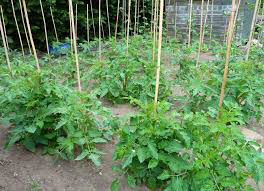

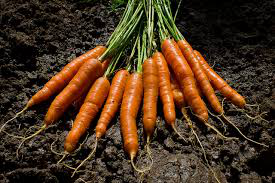

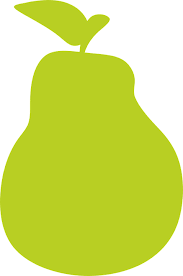

[None, None, None]

In [42]:
mask = df['label'] == 'O'
[display.display(Image.open(file_path)) for file_path in df[mask]['file_path'].head(3)]

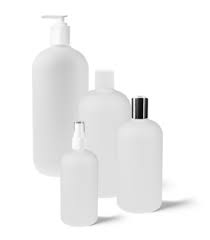

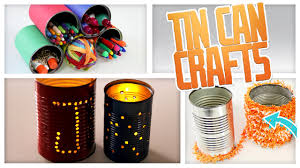

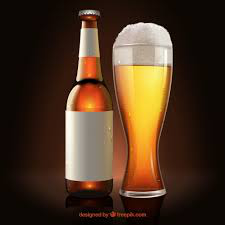

[None, None, None]

In [43]:
mask = df['label'] == 'R'
[display.display(Image.open(file_path)) for file_path in df[mask]['file_path'].head(3)]

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label(file_path):
  path_parts = file_path.split('/')
  file_name = path_parts[-1]
  label = path_parts[-2]
  purpose = path_parts[-3]
  #print(f'file_name:{file_name}')
  #print(f'label:{label}')
  #print(f'purpose:{purpose}')
  return label

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
list_ds = tf.data.Dataset.list_files(str(path/'*/*/*.jpg'))

In [47]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TRAIN/R/R_3498.jpg'
b'/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TRAIN/R/R_2827.jpg'
b'/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TRAIN/O/O_8559.jpg'
b'/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TRAIN/O/O_6388.jpg'
b'/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/TRAIN/O/O_4659.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  IMG_HEIGHT = 224
  IMG_WIDTH = 224
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [53]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

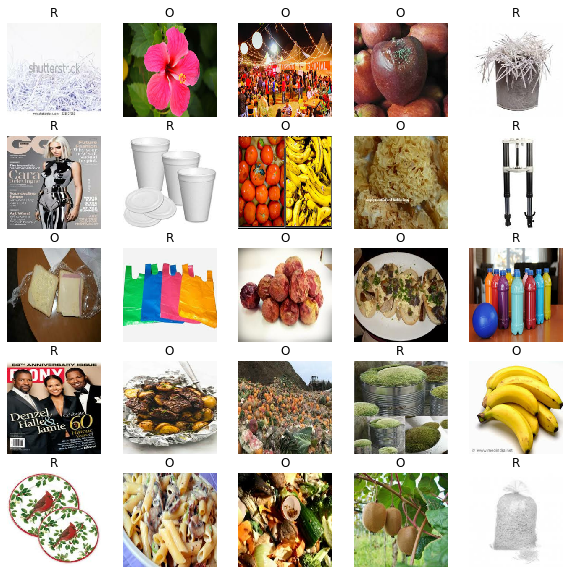

In [58]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [0]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

NameError: ignored